In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from util   import *
from basics import *
from simulate_data import *
from estimators    import *
from config import *
configure_pylab()   

## Simulate grid cell data 

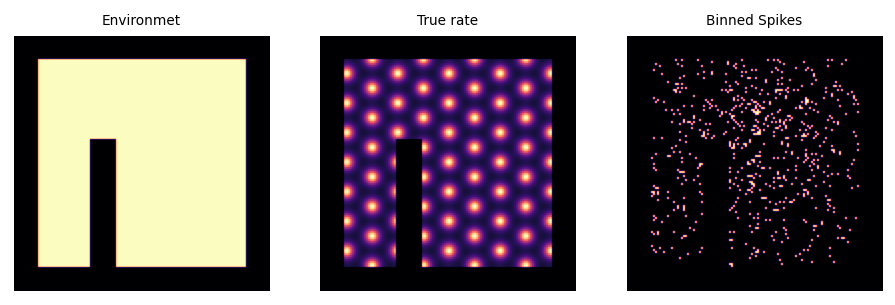

In [2]:
L = 128  # Grid size
P = L/10 # Grid spacing
α = 0.5  # Grid "sharpness"
μ = 1500/L**2 # Mean firing rate (spikes per sample)
mask,λ0,λ0_bg,N,K = simulate_data(L,P,α,μ)
subplot(131); showim(mask,'Environmet')
subplot(132); showim(λ0,'True rate')
subplot(133); showim(K,'Binned Spikes');

## Biased per-bin histogram estimator

K/N Estimator:
∙ Normalized MSE: 236.4%
∙ Pearson correlation: 0.16
Regularized Estimator:
∙ Normalized MSE: 168.1%
∙ Pearson correlation: 0.16


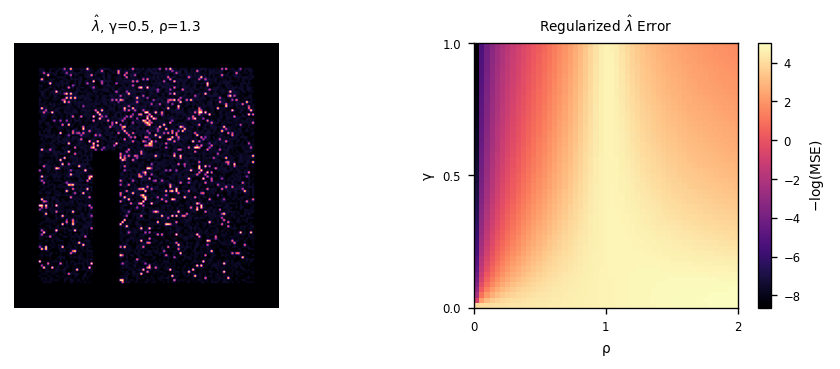

In [3]:
# Rate per bin using naive and regularized estimators
λhat1 = nan_to_num(K/N)
λhat2 = biased_rate(N,K)
printstats(λ0,λhat1,'K/N Estimator',mask)
printstats(λ0,λhat2,'Regularized Estimator',mask)
ρs,γs = linspace(1e-2,2,51),linspace(0,1,51)
MAE = array([[mean(abs(λ0-biased_rate(N,K,ρ,γ))**2) for ρ in ρs] for γ in γs])
subplot(121); showim(λhat2,'$\hat\lambda$, γ=0.5, ρ=1.3')
subplot(122); imshow(-log(MAE),extent=(0,2,0,1),aspect=2)
xticks([0,1,2]); yticks([0,.5,1]); xlabel('ρ'); ylabel('γ');
title('Regularized $\hat\lambda$ Error')
colorbar(label='$-\log(\operatorname{MSE})$');

## Estimating grid period from autocorrelogram 

Estimated period is P=12.6


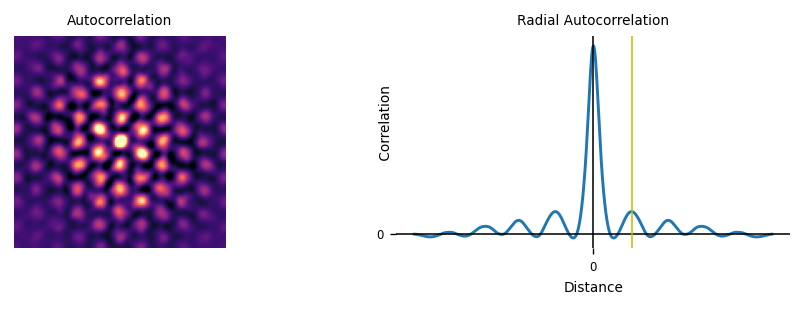

In [4]:
P, Δs, acup, acorr2 = estimate_period_via_autocorrelation(N,K,mask)
print('Estimated period is P=%s'%P)
figure(figsize=(8,2))
subplot(121); showim(acorr2,'Autocorrelation')
subplot(122); plot(Δs,acup)
[gca().spines[s].set_visible(0) for s in ['top','right','bottom','left']]
axhline(0,color='k',lw=.8); xticks([0]); xlabel('Distance'); 
axvline(0,color='k',lw=.8); yticks([0]); ylabel(' '*9+'Correlation',labelpad=-9)
axvline((0+1+P),color='y',lw=.8);
title('Radial Autocorrelation');

## KDE smoothing with squared exponential kernel

KDE:
∙ Normalized MSE: 55.8%
∙ Pearson correlation: 0.53


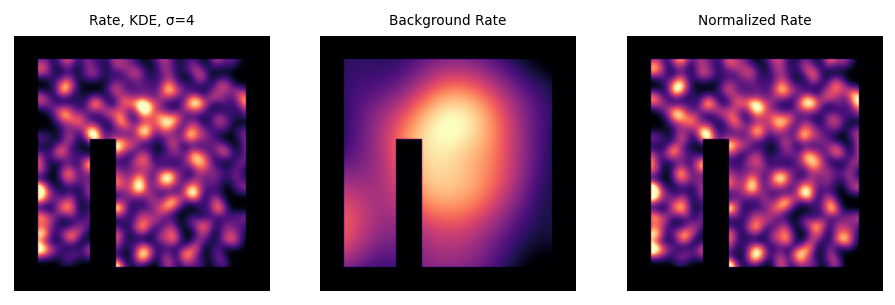

In [5]:
fgσ  = P/pi
bgσ  = fgσ*5
λhat = kdeλ(N,K,fgσ) 
λbg  = kdeλ(N,K,bgσ)
λbar = λhat/λbg
printstats(λ0,λhat,'KDE')
subplot(131); showim(λhat,'Rate, KDE, σ=%d'%fgσ,mask=mask);
subplot(132); showim(λbg ,'Background Rate',mask=mask);
subplot(133); showim(λbar,'Normalized Rate',mask=mask);

## Linear Gaussian process with squared-exponential kernel

GP regression error:
∙ Normalized MSE: 67.0%
∙ Pearson correlation: 0.29


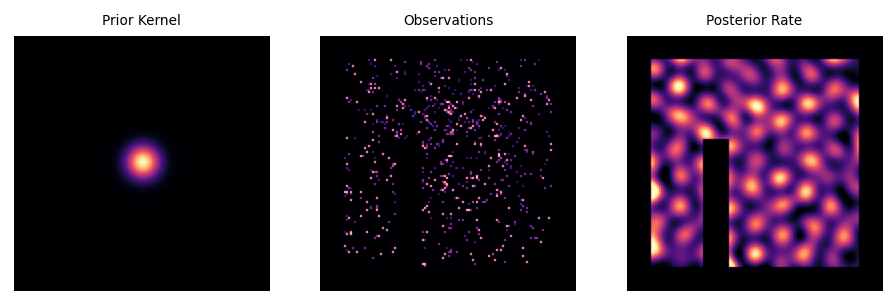

In [6]:
λGP1,kern,y = linearGP(N,K,fgσ,mask)
printstats(λ0,λGP1,'GP regression error')
subplot(131); showkn(kern,'Prior Kernel');
subplot(132); showim(y,'Observations');
subplot(133); showim(λGP1/λbg,'Posterior Rate',mask=mask);

## Linear GP: connection to convolution

Error between GP regression and convolution:
∙ Normalized MSE: 109.5%
∙ Pearson correlation: 0.58
Error between convolution and true:
∙ Normalized MSE: 53.9%
∙ Pearson correlation: 0.49


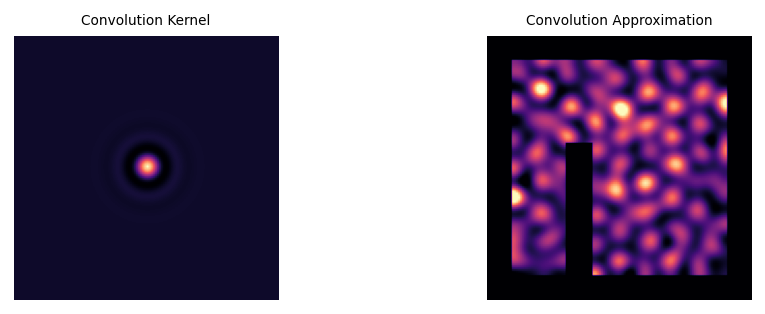

In [7]:
λcnv, gft = convolutionalLinearGP(N,K,fgσ,mask)
printstats(λcnv,λGP1,'Error between GP regression and convolution')
printstats(λ0,λcnv,'Error between convolution and true')
subplot(121); showkn(real(ifft2(gft)),'Convolution Kernel');
subplot(122); showim(λcnv/λbg,'Convolution Approximation',mask=mask);

## Kernel construction 1: use autocorrelation of reference grid

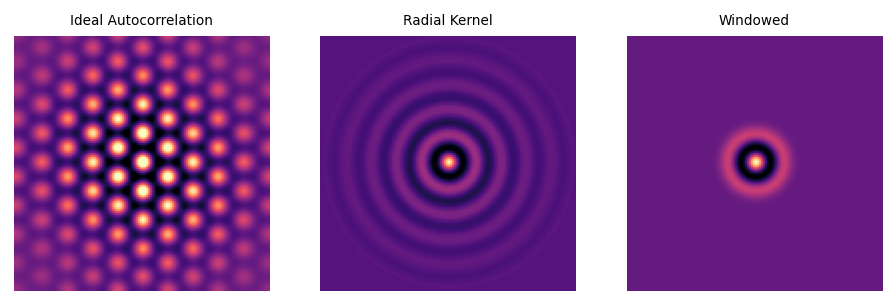

In [8]:
# Make symmetric kernel from autocorrelation of ideal grid
acgrd  = fft_acorr(ideal_hex_grid(L,P),mask)
kernR  = radial_kernel(radial_average(acgrd))
coords = zgrid(L)
# Restrict kernel to local neighborhood and normalize
window = abs(coords)<P*8.6537/(2*pi)
kern0  = kernR*fftshift(window)
kern0  = blur(kernR*fftshift(window),P/pi)
kern0  = kern0/np.max(kern0)
subplot(131); showim(acgrd,'Ideal Autocorrelation')
subplot(132); showkn(kernR,'Radial Kernel')
subplot(133); showkn(kern0,'Windowed')

## Kernel construction 2: Bessel function 

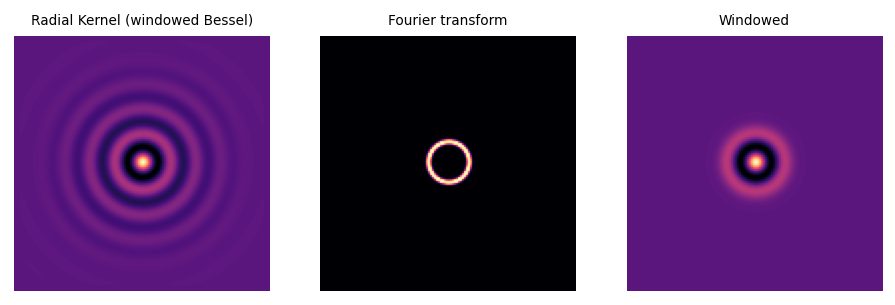

In [9]:
from scipy.special import *

# Bessel function
coords = zgrid(L)
kernR  = j0(fftshift(abs(coords*2*pi/P)))
window = hanning(L)
window = outer(window,window)
kernR  = kernR*fftshift(window)
fftkr  = fftshift(real(ifft2(kernR)))

# Restrict kernel to local neighborhood and normalize
k3     = jn_zeros(0,3)[-1]
window = abs(coords)<P*k3/(2*pi)
kern0  = kernR*fftshift(window)
kern0  = blur(kernR*fftshift(window),P/pi)
kern0  = kern0/np.max(kern0)

subplot(131); showkn(kernR,'Radial Kernel (windowed Bessel)')
subplot(132); showim(fftkr,'Fourier transform')
subplot(133); showkn(kern0,'Windowed')

## Linear GP heuristic calibration: scale to match autocorrelation

GP with periodic kernel:
∙ Normalized MSE: 48.1%
∙ Pearson correlation: 0.63


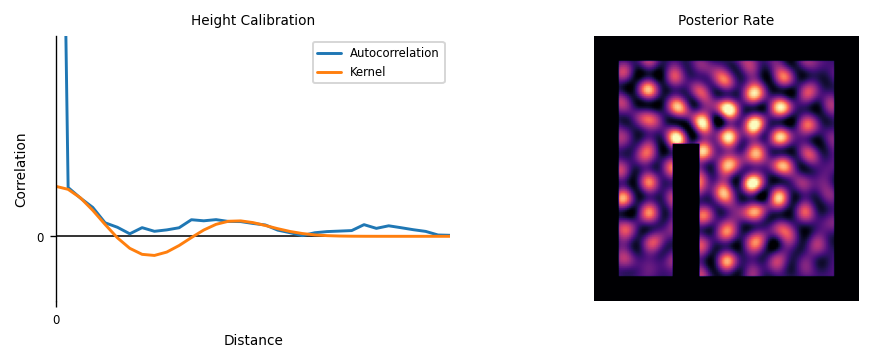

In [10]:
# Estimate zero-lag variance and scale kernel
acorrR1 = radial_acorr(biased_rate(N,K),mask)
acorrR2 = np0.array(acorrR1)
v0      = zerolag(acorrR1)
kern    = kern0*v0
acorrR2[L//2] = v0
ε0      = mean((K/N)[N>0])

λGP2 = solveGP(kern,y,N.ravel()/ε0,mask)

printstats(λ0,λGP2,'GP with periodic kernel')
subplot(121)
axhline(0,color='k',lw=.8)
plot(acorrR1[L//2:],label='Autocorrelation')
plot(kern[0,:L//2] ,label='Kernel')
xticks([0]); xlabel('Distance');    xlim(0,L//4)
yticks([0]); ylabel('Correlation'); ylim(ylim()[0],v0*4)
[gca().spines[s].set_visible(0) for s in ['top','right','bottom']];
legend(); title('Height Calibration')
subplot(122); showim(λGP2,t='Posterior Rate',mask=mask);

## MAP Log-Gaussian Cox process with heuristic calibration 

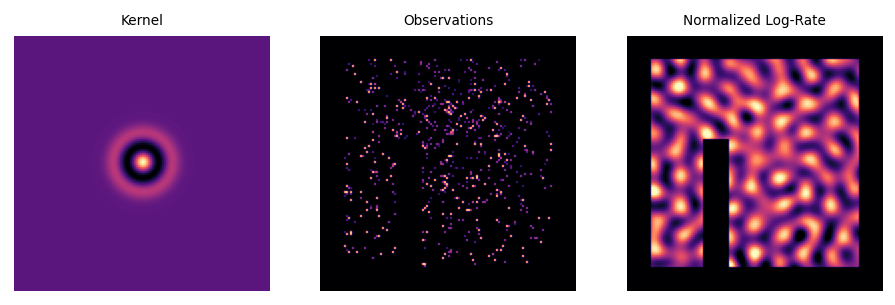

In [20]:
fgσ    = P/pi
bgσ    = fgσ*5

# Bessel function
coords = zgrid(L)
kernR  = j0(fftshift(abs(coords*2*pi/P)))
window = hanning(L)
kernR  = kernR*fftshift(outer(window,window))
fftkr  = fftshift(real(ifft2(kernR)))

# Restrict kernel to local neighborhood and normalize
k3     = jn_zeros(0,3)[-1]
win2   = abs(coords)<P*k3/(2*pi)
kern0  = kernR*fftshift(win2)
kern0  = blur(kern0,P/pi)
kern0  = kern0/np.max(kern0)

# Prepare data
lλb  = slog(kdeλ(N,K,bgσ))     # Log background (initial estimate)
lλf  = slog(kdeλ(N,K,fgσ))-lλb # Log foreground (initial estimate)
n    = N.ravel()               # Number of visits per bin
y    = nan_to_num(K/N).ravel() # Lumped pseudo-observerations
lλb  = lλb.ravel()             # Background offsets

# Heuristic kernel
kern = kern0*zerolag(radial_acorr(lλf,mask))
knft = real(fft2(repair_small_eigenvalues(kern,1e-4)))
knft[0,0] += 100
kift = 1.0/knft

# Prepare gradient and hessian operators
M  = cop(knft)
Ki = cop(kift)
J  = lambda w: Ki@w + n*(exp(w+lλb)-y)
H  = lambda w: Ki   + diagop(n*exp(w+lλb))

# Fit model and unpack result
w2  = newton_raphson(lλf,J,H,M)
subplot(131); showkn(kern,'Kernel');
subplot(132); showim(y   ,'Observations');
subplot(133); showim(w2  ,'Normalized Log-Rate',mask=mask);

# Why is it so bad? 

- Model likelihood for Laplace remains unresolved
- Is background subtraction the wrong approach? should I be modifying the kernel instead? 
- Gradients for scale parameter for any of this? 